In [1]:
import numpy as np  # this module handles arrays, but here we need it for its NaN value
import pandas as pd # this module contains a lot of tools for handling tabular data
from matplotlib import pyplot as plt
from salishsea_tools import evaltools as et
import datetime as dt
import os
import gsw
import pickle
import netCDF4 as nc
import cmocean
from scipy import stats as spst
%matplotlib inline

In [2]:
modSourceDir= '/results/SalishSea/nowcast-green.201812/'
modver='201812'
Chl_N=1.8 # Chl:N ratio
start_date = dt.datetime(2015,1,1)
end_date = dt.datetime(2018,12,31) #dt.datetime(2019,6,30)

In [3]:
# Parameters
modSourceDir = "/results/SalishSea/nowcast-green.201812/"
modver = "201812"
Chl_N = 1.8


In [4]:
datestr='_'+start_date.strftime('%Y%m%d')+'_'+end_date.strftime('%Y%m%d')

In [5]:
def subval(idf,colList):
    # first value in colList should be the column you are going to keep
    # follow with other columns that will be used to fill in when that column is NaN
    # in order of precedence
    if len(colList)==2:
        idf[colList[0]]=[r[colList[0]] if not pd.isna(r[colList[0]]) \
                         else  r[colList[1]] for i,r in idf.iterrows()]
    elif len(colList)==3:
        idf[colList[0]]=[r[colList[0]] if not pd.isna(r[colList[0]]) \
                         else  r[colList[1]] if not pd.isna(r[colList[1]]) \
                         else r[colList[2]] for i,r in idf.iterrows()]
    else:
        raise NotImplementedError('Add to code to handle this case')
    idf.drop(columns=list(colList[1:]),inplace=True)
    return idf

In [6]:
if os.path.isfile('matched_'+modver+datestr+'.pkl'):
    data=pickle.load(open( 'matched_'+modver+datestr+'.pkl', 'rb' ) )
else:
    # define paths to the source files and eventual output file
    flist=('/ocean/eolson/MEOPAR/obs/NemcekHPLC/bottlePhytoMerged2015.csv',
           '/ocean/eolson/MEOPAR/obs/NemcekHPLC/bottlePhytoMerged2016.csv',
           '/ocean/eolson/MEOPAR/obs/NemcekHPLC/bottlePhytoMerged2017.csv',
           '/ocean/eolson/MEOPAR/obs/NemcekHPLC/bottlePhytoMerged2018.csv')#,
           #'/ocean/eolson/MEOPAR/obs/NemcekHPLC/bottlePhytoMerged2019.csv')

    dfs=list()
    for fname in flist:
        idf=pd.read_csv(fname)
        print(fname,sorted(idf.keys()))
        dfs.append(idf)
    df=pd.concat(dfs,ignore_index=True,sort=False); # concatenate the list into a single table

    df.drop(labels=['ADM:MISSION','ADM:PROJECT','ADM:SCIENTIST','Zone','Zone.1','Temperature:Draw',
                    'Temperature:Draw [deg C (ITS90)]','Bottle:Firing_Sequence','Comments by sample_numbeR',
                    'File Name','LOC:EVENT_NUMBER','Number_of_bin_records'
                       ],axis=1,inplace=True)

    df=subval(df,('Dictyochophytes','Dictyo'))
    df=subval(df,('Chlorophyll:Extracted [mg/m^3]','Chlorophyll:Extracted'))
    df=subval(df,('Dinoflagellates','Dinoflagellates-1'))
    df=subval(df,('Fluorescence [mg/m^3]','Fluorescence:URU:Seapoint [mg/m^3]','Fluorescence:URU:Seapoint'))
    df=subval(df,('Lat','LOC:LATITUDE'))
    df=subval(df,('Lon','LOC:LONGITUDE'))
    df=subval(df,('Nitrate_plus_Nitrite [umol/L]','Nitrate_plus_Nitrite'))
    df=subval(df,('PAR [uE/m^2/sec]','PAR'))
    df=subval(df,('Phaeo-Pigment:Extracted [mg/m^3]','Phaeo-Pigment:Extracted'))
    df=subval(df,('Phosphate [umol/L]','Phosphate'))
    df=subval(df,('Pressure [decibar]','Pressure'))
    df=subval(df,('Raphidophytes','Raphido'))
    df=subval(df,('Salinity','Salinity [PSS-78]','Salinity:T1:C1 [PSS-78]'))
    df=subval(df,('Salinity:Bottle','Salinity:Bottle [PSS-78]'))
    df=subval(df,('Silicate [umol/L]','Silicate'))
    df=subval(df,('TchlA (ug/L)','TchlA'))
    df=subval(df,('Temperature','Temperature [deg C (ITS90)]','Temperature:Secondary [deg C (ITS90)]'))
    df=subval(df,('Transmissivity [*/metre]','Transmissivity'))

    df['Z']=np.where(pd.isna(df['Depth [metres]']),
                     -1*gsw.z_from_p(df['Pressure [decibar]'],df['Lat']),
                     df['Depth [metres]'])
    df['p']=np.where(pd.isna(df['Pressure [decibar]']),
                     gsw.p_from_z(-1*df['Depth [metres]'],df['Lat']),
                    df['Pressure [decibar]'])
    df['SA']=gsw.SA_from_SP(df['Salinity'],df['p'],df['Lon'],df['Lat'])
    df['CT']=gsw.CT_from_t(df['SA'],df['Temperature'],df['p'])

    df['dtUTC']=[dt.datetime.strptime(ii,'%Y-%m-%d %H:%M:%S') if isinstance(ii,str) else np.nan for ii in df['FIL:START TIME YYYY/MM/DD HH:MM:SS'] ]

    PATH= modSourceDir

    flen=1
    namfmt='nowcast'
    #varmap={'N':'nitrate','Si':'silicon','Ammonium':'ammonium'}
    filemap={'nitrate':'ptrc_T','silicon':'ptrc_T','ammonium':'ptrc_T','diatoms':'ptrc_T','ciliates':'ptrc_T','flagellates':'ptrc_T','vosaline':'grid_T','votemper':'grid_T'}
    #gridmap={'nitrate':'tmask','silicon':'tmask','ammonium':'tmask'}
    fdict={'ptrc_T':1,'grid_T':1}

    data=et.matchData(df,filemap,fdict,start_date,end_date,namfmt,PATH,flen)

    with open('matched_'+modver+datestr+'.pkl','wb') as f:
        pickle.dump(data,f)

In [7]:
data['other']=0.0
for el in ('Cryptophytes', 'Cyanobacteria', 'Dictyochophytes', 'Dinoflagellates',
    'Haptophytes', 'Prasinophytes', 'Raphidophytes'):
    data['other']=data['other']+data[el]

(0, 8)

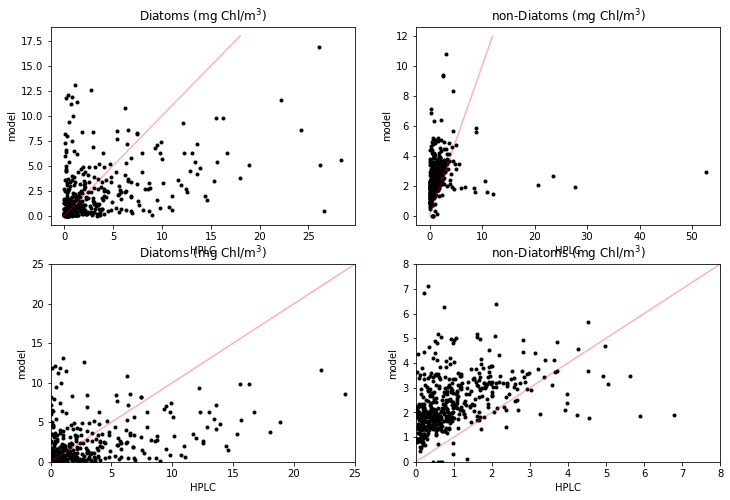

In [8]:
fig,ax=plt.subplots(2,2,figsize=(12,8))
ax=ax.flatten()
ax[0].plot(data['Diatoms-1']+data['Diatoms-2'],1.8*data['mod_diatoms'],'k.')
ax[0].set_title('Diatoms (mg Chl/m$^3$)')
ax[0].set_xlabel('HPLC')
ax[0].set_ylabel('model')
ax[0].plot((0,18),(0,18),'r-',alpha=.3)

ax[1].plot(data['other'],1.8*(data['mod_flagellates']+data['mod_ciliates']),'k.')
ax[1].set_title('non-Diatoms (mg Chl/m$^3$)')
ax[1].set_xlabel('HPLC')
ax[1].set_ylabel('model')
ax[1].plot((0,12),(0,12),'r-',alpha=.3)

ax[2].plot(data['Diatoms-1']+data['Diatoms-2'],1.8*data['mod_diatoms'],'k.')
ax[2].set_title('Diatoms (mg Chl/m$^3$)')
ax[2].set_xlabel('HPLC')
ax[2].set_ylabel('model')
ax[2].plot((0,25),(0,25),'r-',alpha=.3)
ax[2].set_xlim((0,25))
ax[2].set_ylim((0,25))

ax[3].plot(data['other'],1.8*(data['mod_flagellates']+data['mod_ciliates']),'k.')
ax[3].set_title('non-Diatoms (mg Chl/m$^3$)')
ax[3].set_xlabel('HPLC')
ax[3].set_ylabel('model')
ax[3].plot((0,12),(0,12),'r-',alpha=.3)
ax[3].set_xlim((0,8))
ax[3].set_ylim((0,8))

In [9]:
def logt(x):
    return np.log10(x+.001)

(-3.1, 2)

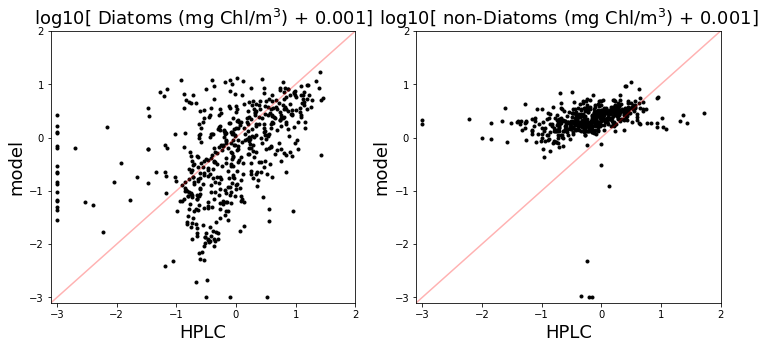

In [10]:
fig,ax=plt.subplots(1,2,figsize=(12,5))
ax[0].plot(logt(data['Diatoms-1']+data['Diatoms-2']),logt(1.8*data['mod_diatoms']),'k.')
ax[0].set_title('log10[ Diatoms (mg Chl/m$^3$) + 0.001]',fontsize=18)
ax[0].set_xlabel('HPLC',fontsize=18)
ax[0].set_ylabel('model',fontsize=18)
ax[0].set_xlim(-3.1,2)
ax[0].set_ylim(-3.1,2)
ax[0].plot((-6,3),(-6,3),'r-',alpha=.3)

ax[1].plot(logt(data['other']),logt(1.8*(data['mod_flagellates']+data['mod_ciliates'])),'k.')
ax[1].set_title('log10[ non-Diatoms (mg Chl/m$^3$) + 0.001]',fontsize=18)
ax[1].set_xlabel('HPLC',fontsize=18)
ax[1].set_ylabel('model',fontsize=18)
ax[1].plot((-6,3),(-6,3),'r-',alpha=.3)
ax[1].set_xlim(-3.1,2)
ax[1].set_ylim(-3.1,2)

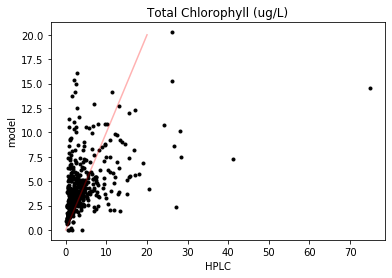

In [11]:
plt.plot(data['TchlA (ug/L)'],1.8*(data['mod_flagellates']+data['mod_ciliates']+data['mod_diatoms']),'k.')
plt.title('Total Chlorophyll (ug/L)')
plt.xlabel('HPLC')
plt.ylabel('model')
plt.plot((0,20),(0,20),'r-',alpha=.3)

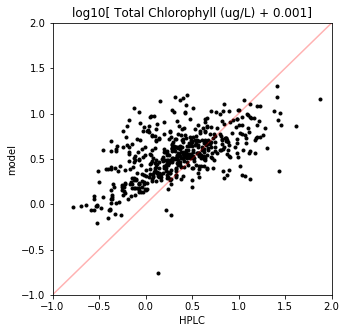

In [12]:
fig,ax=plt.subplots(1,1,figsize=(5,5))
ax.plot(logt(data['TchlA (ug/L)']),logt(1.8*(data['mod_flagellates']+data['mod_ciliates']+data['mod_diatoms'])),'k.')
ax.set_title('log10[ Total Chlorophyll (ug/L) + 0.001]')
ax.set_xlabel('HPLC')
ax.set_ylabel('model')
ax.plot((-6,5),(-6,5),'r-',alpha=.3)
ax.set_xlim(-1,2)
ax.set_ylim(-1,2);

In [13]:
def yd(idt):
    if type(idt)==dt.datetime:
        yd=(idt-dt.datetime(idt.year-1,12,31)).days
    else: # assume array or pandas
        yd=[(ii-dt.datetime(ii.year-1,12,31)).days for ii in idt]
    return yd

data['yd']=yd(data['dtUTC'])
data['Year']=[ii.year for ii in data['dtUTC']]

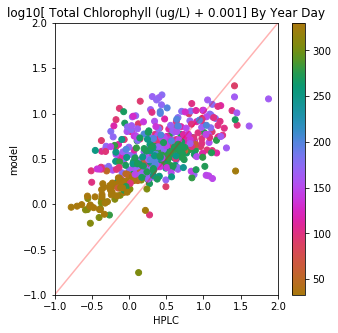

In [14]:
fig,ax=plt.subplots(1,1,figsize=(5,5))
m=ax.scatter(logt(data['TchlA (ug/L)']),logt(1.8*(data['mod_flagellates']+data['mod_ciliates']+data['mod_diatoms'])),
          c=data['yd'],cmap=cmocean.cm.phase)
ax.set_title('log10[ Total Chlorophyll (ug/L) + 0.001] By Year Day')
ax.set_xlabel('HPLC')
ax.set_ylabel('model')
ax.plot((-6,5),(-6,5),'r-',alpha=.3)
ax.set_xlim(-1,2)
ax.set_ylim(-1,2);
fig.colorbar(m)

In [15]:
with nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702_noLPE.nc') as mesh:
    tmask=np.copy(mesh.variables['tmask'][0,:,:,:])
    navlat=np.copy(mesh.variables['nav_lat'][:,:])
    navlon=np.copy(mesh.variables['nav_lon'][:,:])

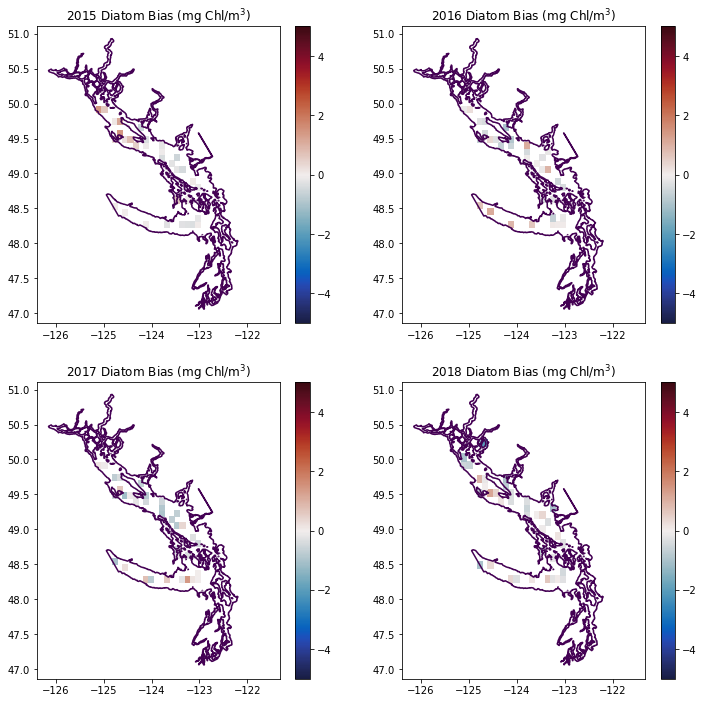

In [16]:
fig,ax=plt.subplots(2,2,figsize=(12,12))
ax=ax.flatten()
for yr in range(2015,2019):
    dyr=data.loc[(data['Year']==yr)&(~np.isnan(data['Lon']))&(~np.isnan(data['Lat']))&~np.isnan(data['other'])&~np.isnan(data['mod_diatoms'])]
    ax[yr-2015].contour(navlon,navlat,tmask[0,:,:],(0.5,))
    ax[yr-2015].set_title(str(yr)+' Diatom Bias (mg Chl/m$^3$)')
    s,xb,yb,nb=spst.binned_statistic_2d(dyr['Lon'],dyr['Lat'],
                logt(1.8*dyr['mod_diatoms'])-logt(dyr['Diatoms-1']+dyr['Diatoms-2']), 
                statistic='mean', bins=20)
    m=ax[yr-2015].pcolormesh(xb,yb,s.T,cmap=cmocean.cm.balance,vmin=-5,vmax=5,shading='flat')
    plt.colorbar(m,ax=ax[yr-2015])

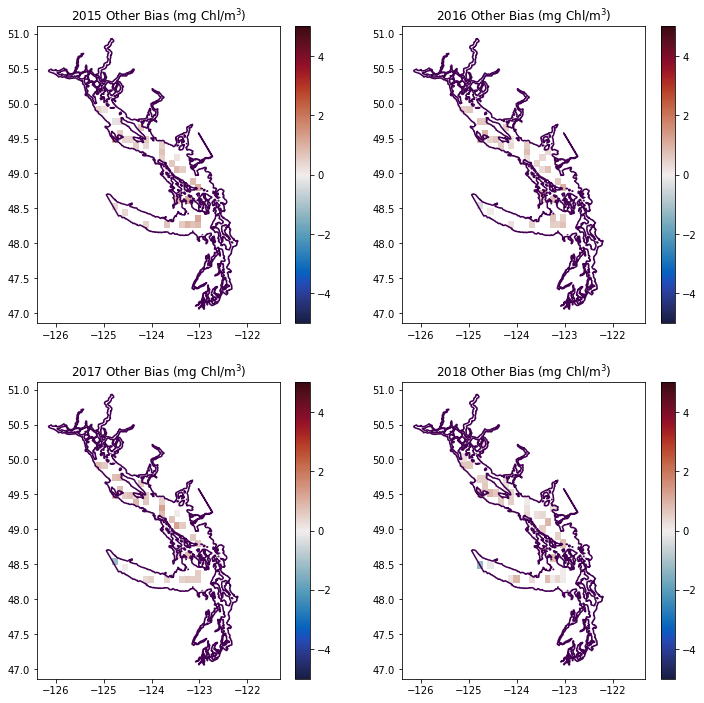

In [17]:
fig,ax=plt.subplots(2,2,figsize=(12,12))
ax=ax.flatten()
for yr in range(2015,2019):
    dyr=data.loc[(data['Year']==yr)&(~np.isnan(data['Lon']))&(~np.isnan(data['Lat']))&~np.isnan(data['other'])&~np.isnan(data['mod_diatoms'])]
    ax[yr-2015].contour(navlon,navlat,tmask[0,:,:],(0.5,))
    ax[yr-2015].set_title(str(yr)+' Other Bias (mg Chl/m$^3$)')
    s,xb,yb,nb=spst.binned_statistic_2d(dyr['Lon'],dyr['Lat'],
                logt(1.8*(dyr['mod_flagellates']+dyr['mod_ciliates']))-logt(dyr['other']), 
                statistic='mean', bins=20)
    m=ax[yr-2015].pcolormesh(xb,yb,s.T,cmap=cmocean.cm.balance,vmin=-5,vmax=5,shading='flat')
    plt.colorbar(m,ax=ax[yr-2015])

Text(0, 0.5, 'log(mod)-log(hplc)')

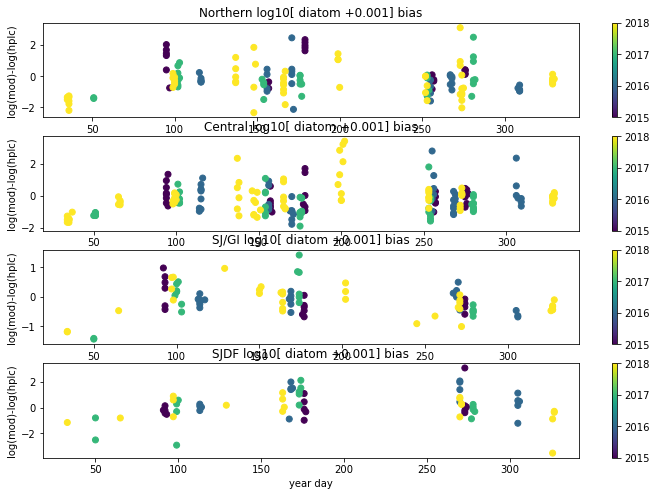

In [18]:
fig,ax=plt.subplots(4,1,figsize=(12,8))
r1=data.Lat>49.5
r2=(data.Lat<49.5)&(data.Lat>48.8)
r3=(data.Lat<48.8)&(data.Lon>-123.5)
r4=(data.Lat<48.8)&(data.Lon<-123.5)
xx=data.loc[r1,['yd']].values
yy=logt(1.8*(data.loc[r1,['mod_diatoms']].values))-logt(data.loc[r1,['Diatoms-1']].values+data.loc[r1,['Diatoms-2']].values)
colors=[ii.year for ind,ii in zip(range(0,len(data['dtUTC'])),data['dtUTC']) if r1[ind]]
m=ax[0].scatter(xx[:,0],yy[:,0],c=colors)
fig.colorbar(m,ax=ax[0])
ax[0].set_title('Northern log10[ diatom +0.001] bias')
ax[0].set_xlabel('year day')
ax[0].set_ylabel('log(mod)-log(hplc)')

r=r2
xx=data.loc[r,['yd']].values
yy=logt(1.8*(data.loc[r,['mod_diatoms']].values))-logt(data.loc[r,['Diatoms-1']].values+data.loc[r,['Diatoms-2']].values)
colors=[ii.year for ind,ii in zip(range(0,len(data['dtUTC'])),data['dtUTC']) if r[ind]]
m=ax[1].scatter(xx[:,0],yy[:,0],c=colors)
fig.colorbar(m,ax=ax[1])
ax[1].set_title('Central log10[ diatom +0.001] bias')
ax[1].set_xlabel('year day')
ax[1].set_ylabel('log(mod)-log(hplc)')

r=r3
xx=data.loc[r,['yd']].values
yy=logt(1.8*(data.loc[r,['mod_diatoms']].values))-logt(data.loc[r,['Diatoms-1']].values+data.loc[r,['Diatoms-2']].values)
colors=[ii.year for ind,ii in zip(range(0,len(data['dtUTC'])),data['dtUTC']) if r[ind]]
m=ax[2].scatter(xx[:,0],yy[:,0],c=colors)
fig.colorbar(m,ax=ax[2])
ax[2].set_title('SJ/GI log10[ diatom +0.001] bias')
ax[2].set_xlabel('year day')
ax[2].set_ylabel('log(mod)-log(hplc)')

r=r4
xx=data.loc[r,['yd']].values
yy=logt(1.8*(data.loc[r,['mod_diatoms']].values))-logt(data.loc[r,['Diatoms-1']].values+data.loc[r,['Diatoms-2']].values)
colors=[ii.year for ind,ii in zip(range(0,len(data['dtUTC'])),data['dtUTC']) if r[ind]]
m=ax[3].scatter(xx[:,0],yy[:,0],c=colors)
fig.colorbar(m,ax=ax[3])
ax[3].set_title('SJDF log10[ diatom +0.001] bias')
ax[3].set_xlabel('year day')
ax[3].set_ylabel('log(mod)-log(hplc)')

Text(0, 0.5, 'log(mod)-log(hplc)')

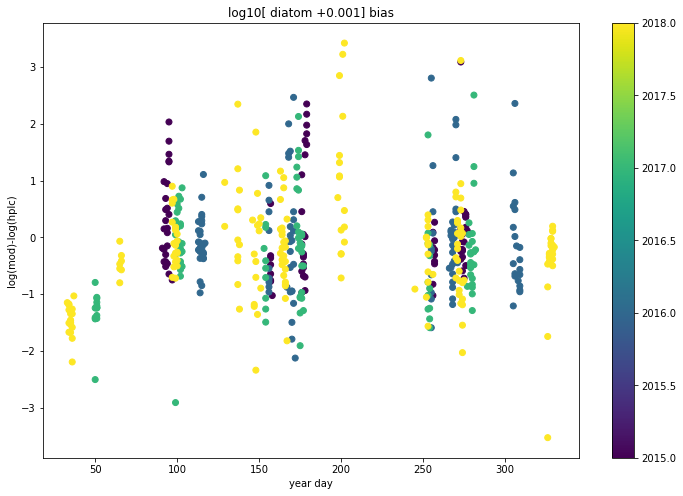

In [19]:
# by region
fig,ax=plt.subplots(1,1,figsize=(12,8))
m=ax.scatter(data['yd'],logt(1.8*(data['mod_diatoms']))-logt(data['Diatoms-1']+data['Diatoms-2']),
             c=[ii.year for ii in data['dtUTC']])
plt.colorbar(m)
ax.set_title('log10[ diatom +0.001] bias')
ax.set_xlabel('year day')
ax.set_ylabel('log(mod)-log(hplc)')

Text(0, 0.5, 'model- HPLC')

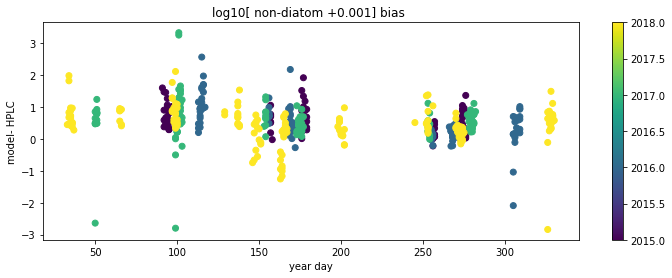

In [20]:
fig,ax=plt.subplots(1,1,figsize=(12,4))
m=ax.scatter(data['yd'],logt(1.8*(data['mod_flagellates']+data['mod_ciliates']))-logt(data['other']),
             c=[ii.year for ii in data['dtUTC']])
plt.colorbar(m)
ax.set_title('log10[ non-diatom +0.001] bias ')
ax.set_xlabel('year day')
ax.set_ylabel('model- HPLC')

(-30, 25)

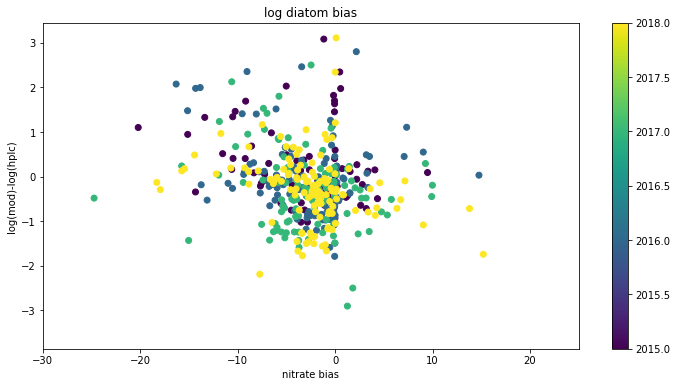

In [21]:
fig,ax=plt.subplots(1,1,figsize=(12,6))
m=ax.scatter(data['mod_nitrate']-data['Nitrate_plus_Nitrite [umol/L]'],logt(1.8*data['mod_diatoms'])-logt(data['Diatoms-1']+data['Diatoms-2']),
             c=[ii.year for ii in data['dtUTC']])
plt.colorbar(m)
ax.set_title('log diatom bias')
ax.set_xlabel('nitrate bias')
ax.set_ylabel('log(mod)-log(hplc)')
ax.set_xlim(-30,25)

(-1, 30)

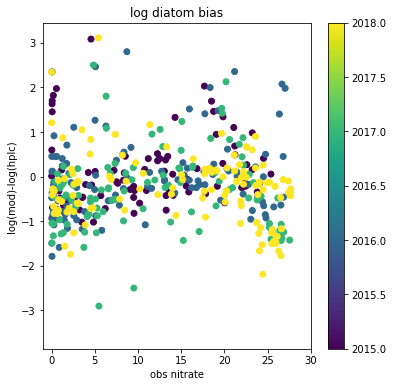

In [22]:
fig,ax=plt.subplots(1,1,figsize=(6,6))
m=ax.scatter(data['Nitrate_plus_Nitrite [umol/L]'],logt(1.8*data['mod_diatoms'])-logt(data['Diatoms-1']+data['Diatoms-2']),
             c=[ii.year for ii in data['dtUTC']])
plt.colorbar(m)
ax.set_title('log diatom bias')
ax.set_xlabel('obs nitrate')
ax.set_ylabel('log(mod)-log(hplc)')
ax.set_xlim(-1,30)

(-0.1, 3)

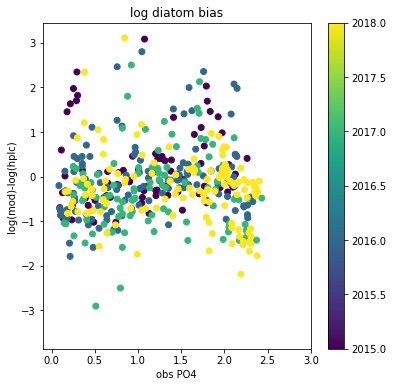

In [23]:
fig,ax=plt.subplots(1,1,figsize=(6,6))
m=ax.scatter(data['Phosphate [umol/L]'],logt(1.8*data['mod_diatoms'])-logt(data['Diatoms-1']+data['Diatoms-2']),
             c=[ii.year for ii in data['dtUTC']])
plt.colorbar(m)
ax.set_title('log diatom bias')
ax.set_xlabel('obs PO4')
ax.set_ylabel('log(mod)-log(hplc)')
ax.set_xlim(-.1,3)

(-1, 70)

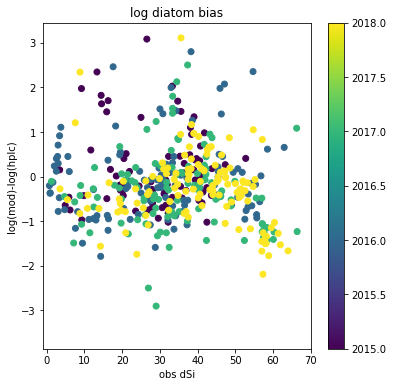

In [24]:
fig,ax=plt.subplots(1,1,figsize=(6,6))
m=ax.scatter(data['Silicate [umol/L]'],logt(1.8*data['mod_diatoms'])-logt(data['Diatoms-1']+data['Diatoms-2']),
             c=[ii.year for ii in data['dtUTC']])
plt.colorbar(m)
ax.set_title('log diatom bias')
ax.set_xlabel('obs dSi')
ax.set_ylabel('log(mod)-log(hplc)')
ax.set_xlim(-1,70)

## Multiple Linear Regression

#### Diatoms

In [25]:
ii=(~pd.isnull(data['mod_diatoms']))&(~pd.isnull(data['Diatoms-1']))&(~pd.isnull(data['Diatoms-2']))&(~pd.isnull(data['Cyanobacteria']))&\
        (~pd.isnull(data['Cryptophytes']))&(~pd.isnull(data['Prasinophytes']))&(~pd.isnull(data['Haptophytes']))&\
        (~pd.isnull(data['Dictyochophytes']))&(~pd.isnull(data['Dinoflagellates']))&(~pd.isnull(data['Raphidophytes']))
A=np.vstack([data.loc[ii]['Diatoms-1'],data.loc[ii]['Diatoms-2'],data.loc[ii]['Cyanobacteria'],data.loc[ii]['Cryptophytes'],
               data.loc[ii]['Prasinophytes'],data.loc[ii]['Haptophytes'],data.loc[ii]['Dictyochophytes'],data.loc[ii]['Dinoflagellates'],
             data.loc[ii]['Raphidophytes'],np.ones(np.shape(data.loc[ii]['Diatoms-1']))]).T
b=data.loc[ii]['mod_diatoms']
m=np.linalg.lstsq(A,b,rcond=None)[0]

In [26]:
m

array([ 0.1461116 ,  0.02313048, -2.31397206,  1.47826858, -0.81415547,
       -0.04395027, -0.24189496, -0.1524798 ,  0.14179773,  0.55578246])

In [27]:
clist=('Diatoms-1','Diatoms-2','Cyanobacteria','Cryptophytes','Prasinophytes','Haptophytes',
        'Dictyochophytes','Dinoflagellates','Raphidophytes','ones')
for c, mm in zip(clist,m):
    print(c,mm)

Diatoms-1 0.1461115991821778
Diatoms-2 0.023130477809363337
Cyanobacteria -2.3139720559151065
Cryptophytes 1.4782685761125942
Prasinophytes -0.8141554674932009
Haptophytes -0.04395026758078864
Dictyochophytes -0.24189495781938905
Dinoflagellates -0.1524798022794198
Raphidophytes 0.1417977308016623
ones 0.5557824554075593


In [28]:
ii=(~pd.isnull(data['mod_diatoms']))&(~pd.isnull(data['Diatoms-1']))&(~pd.isnull(data['Diatoms-2']))&\
        (~pd.isnull(data['Cryptophytes']))&(~pd.isnull(data['Raphidophytes']))
A=np.vstack([data.loc[ii]['Diatoms-1'],data.loc[ii]['Diatoms-2'],data.loc[ii]['Cryptophytes'],
            data.loc[ii]['Raphidophytes'],np.ones(np.shape(data.loc[ii]['Diatoms-1']))]).T
b=data.loc[ii]['mod_diatoms']
m=np.linalg.lstsq(A,b,rcond=None)[0]

In [29]:
clist=('Diatoms-1','Diatoms-2','Cryptophytes','Raphidophytes','ones')
for c, mm in zip(clist,m):
    print(c,mm)

Diatoms-1 0.15610851304121548
Diatoms-2 -0.022104283973487515
Cryptophytes 0.3821125404573701
Raphidophytes 0.09267246105179777
ones 0.5044504026229967


In [30]:
ii=(~pd.isnull(data['mod_diatoms']))&(~pd.isnull(data['Diatoms-1']))&\
        (~pd.isnull(data['Cryptophytes']))&(~pd.isnull(data['Raphidophytes']))
A=np.vstack([data.loc[ii]['Diatoms-1'],data.loc[ii]['Cryptophytes'],
            data.loc[ii]['Raphidophytes'],np.ones(np.shape(data.loc[ii]['Diatoms-1']))]).T
b=data.loc[ii]['mod_diatoms']
m=np.linalg.lstsq(A,b,rcond=None)[0]

In [31]:
clist=('Diatoms-1','Cryptophytes','Raphidophytes','ones')
for c, mm in zip(clist,m):
    print(c,mm)

Diatoms-1 0.15594754152703202
Cryptophytes 0.3784930664990568
Raphidophytes 0.09178847050301298
ones 0.5004773386944285


#### flagellates

In [32]:
ii=(~pd.isnull(data['mod_flagellates']))&(~pd.isnull(data['Diatoms-1']))&(~pd.isnull(data['Diatoms-2']))&(~pd.isnull(data['Cyanobacteria']))&\
        (~pd.isnull(data['Cryptophytes']))&(~pd.isnull(data['Prasinophytes']))&(~pd.isnull(data['Haptophytes']))&\
        (~pd.isnull(data['Dictyochophytes']))&(~pd.isnull(data['Dinoflagellates']))&(~pd.isnull(data['Raphidophytes']))
A=np.vstack([data.loc[ii]['Diatoms-1'],data.loc[ii]['Diatoms-2'],data.loc[ii]['Cyanobacteria'],data.loc[ii]['Cryptophytes'],
               data.loc[ii]['Prasinophytes'],data.loc[ii]['Haptophytes'],data.loc[ii]['Dictyochophytes'],data.loc[ii]['Dinoflagellates'],
             data.loc[ii]['Raphidophytes'],np.ones(np.shape(data.loc[ii]['Diatoms-1']))]).T
b=data.loc[ii]['mod_flagellates']
m=np.linalg.lstsq(A,b,rcond=None)[0]

In [33]:
m

array([ 0.010958  , -0.06728288,  1.5784138 ,  0.55221973,  0.18442328,
        0.25904224,  0.13220077,  0.09301702, -0.03950114,  0.67295675])

In [34]:
clist=('Diatoms-1','Diatoms-2','Cyanobacteria','Cryptophytes','Prasinophytes','Haptophytes',
        'Dictyochophytes','Dinoflagellates','Raphidophytes','ones')
for c, mm in zip(clist,m):
    print(c,mm)

Diatoms-1 0.01095799512224545
Diatoms-2 -0.06728287798013483
Cyanobacteria 1.5784138039580469
Cryptophytes 0.5522197277604812
Prasinophytes 0.18442328222794738
Haptophytes 0.2590422439445318
Dictyochophytes 0.1322007692040354
Dinoflagellates 0.09301702371658432
Raphidophytes -0.039501139563166754
ones 0.6729567467865272


In [35]:
ii=(~pd.isnull(data['mod_flagellates']))&(~pd.isnull(data['Diatoms-1']))&(~pd.isnull(data['Cyanobacteria']))&\
        (~pd.isnull(data['Cryptophytes']))&(~pd.isnull(data['Prasinophytes']))&(~pd.isnull(data['Haptophytes']))&\
        (~pd.isnull(data['Dictyochophytes']))&(~pd.isnull(data['Dinoflagellates']))&(~pd.isnull(data['Raphidophytes']))
A=np.vstack([data.loc[ii]['Diatoms-1'],data.loc[ii]['Cyanobacteria'],data.loc[ii]['Cryptophytes'],
               data.loc[ii]['Prasinophytes'],data.loc[ii]['Haptophytes'],data.loc[ii]['Dictyochophytes'],
             data.loc[ii]['Dinoflagellates'],np.ones(np.shape(data.loc[ii]['Diatoms-1']))]).T
b=data.loc[ii]['mod_flagellates']
m=np.linalg.lstsq(A,b,rcond=None)[0]

In [36]:
clist=('Diatoms-1','Cyanobacteria','Cryptophytes','Prasinophytes','Haptophytes',
        'Dictyochophytes','Dinoflagellates','ones')
for c, mm in zip(clist,m):
    print(c,mm)

Diatoms-1 0.005088551793469988
Cyanobacteria 0.8863588722238661
Cryptophytes 0.5998504352492076
Prasinophytes 0.2027439073948646
Haptophytes 0.2818416587510592
Dictyochophytes 0.06190338602397167
Dinoflagellates 0.01833498721034124
ones 0.6702256702362863


In [37]:
ii=(~pd.isnull(data['mod_flagellates']))&(~pd.isnull(data['Cyanobacteria']))&\
        (~pd.isnull(data['Cryptophytes']))&(~pd.isnull(data['Prasinophytes']))&(~pd.isnull(data['Haptophytes']))&\
        (~pd.isnull(data['Dictyochophytes']))&(~pd.isnull(data['Raphidophytes']))
A=np.vstack([data.loc[ii]['Cyanobacteria'],data.loc[ii]['Cryptophytes'],
               data.loc[ii]['Prasinophytes'],data.loc[ii]['Haptophytes'],data.loc[ii]['Dictyochophytes'],
             np.ones(np.shape(data.loc[ii]['Diatoms-1']))]).T
b=data.loc[ii]['mod_flagellates']
m=np.linalg.lstsq(A,b,rcond=None)[0]

In [38]:
clist=('Cyanobacteria','Cryptophytes','Prasinophytes','Haptophytes',
        'Dictyochophytes','ones')
for c, mm in zip(clist,m):
    print(c,mm)

Cyanobacteria 0.9248939785743201
Cryptophytes 0.592769155988474
Prasinophytes 0.18975008147644779
Haptophytes 0.2794204846195845
Dictyochophytes 0.058845777018170356
ones 0.688074260106763


#### M. rubrum

In [39]:
ii=(~pd.isnull(data['mod_ciliates']))&(~pd.isnull(data['Diatoms-1']))&(~pd.isnull(data['Diatoms-2']))&(~pd.isnull(data['Cyanobacteria']))&\
        (~pd.isnull(data['Cryptophytes']))&(~pd.isnull(data['Prasinophytes']))&(~pd.isnull(data['Haptophytes']))&\
        (~pd.isnull(data['Dictyochophytes']))&(~pd.isnull(data['Dinoflagellates']))&(~pd.isnull(data['Raphidophytes']))
A=np.vstack([data.loc[ii]['Diatoms-1'],data.loc[ii]['Diatoms-2'],data.loc[ii]['Cyanobacteria'],data.loc[ii]['Cryptophytes'],
               data.loc[ii]['Prasinophytes'],data.loc[ii]['Haptophytes'],data.loc[ii]['Dictyochophytes'],data.loc[ii]['Dinoflagellates'],
             data.loc[ii]['Raphidophytes'],np.ones(np.shape(data.loc[ii]['Diatoms-1']))]).T
b=data.loc[ii]['mod_ciliates']
m=np.linalg.lstsq(A,b,rcond=None)[0]

In [40]:
clist=('Diatoms-1','Diatoms-2','Cyanobacteria','Cryptophytes','Prasinophytes','Haptophytes',
        'Dictyochophytes','Dinoflagellates','Raphidophytes','ones')
for c, mm in zip(clist,m):
    print(c,mm)

Diatoms-1 0.014525503919068575
Diatoms-2 0.011395505677502693
Cyanobacteria 0.2710109702166438
Cryptophytes 0.005991003225883295
Prasinophytes 0.0018586582284126508
Haptophytes 0.040540304039717506
Dictyochophytes -0.04121046148561792
Dinoflagellates 0.03735938858964069
Raphidophytes -0.007362533398894991
ones 0.29632175969544594


Diatoms:
- Cryptophytes 0.38
- Diatoms-1 0.16
- Raphidophytes 0.09

Flagellates:
- Cyanobacteria 0.9248939785743201
- Cryptophytes 0.592769155988474
- Prasinophytes 0.18975008147644779
- Haptophytes 0.2794204846195845
- Dictyochophytes 0.058845777018170356

M. rubrum:
- Cyanobacteria 0.2710109702166438

None:
- Diatoms-2
- Dinoflagellates

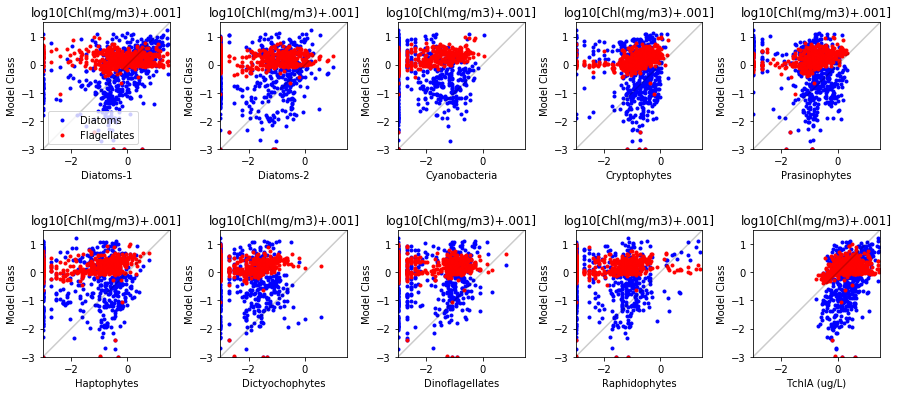

In [41]:
fig,ax=plt.subplots(2,5,figsize=(15,7))
fig.subplots_adjust(wspace=.4)
ax=ax.flatten()

chplc=('Diatoms-1', 'Diatoms-2','Cyanobacteria','Cryptophytes', 'Prasinophytes', 
       'Haptophytes',  'Dictyochophytes','Dinoflagellates','Raphidophytes','TchlA (ug/L)')

mvar1=1.8*data['mod_diatoms']
mvar2=1.8*data['mod_flagellates']

for ii in range(0,len(chplc)):
    ax[ii].plot(logt(data.loc[:,[chplc[ii]]].values),logt(mvar1),'.',color='blue',label='Diatoms')
    ax[ii].plot(logt(data.loc[:,[chplc[ii]]].values),logt(mvar2),'.',color='red',label='Flagellates')
    ax[ii].set_ylabel('Model Class')
    ax[ii].set_xlabel(chplc[ii])
    ax[ii].set_title('log10[Chl(mg/m3)+.001]')
    ax[ii].plot((-3,1.5),(-3,1.5),'k-',alpha=.2)
    ax[ii].set_xlim((-3,1.5))
    ax[ii].set_ylim((-3,1.5))
    ax[ii].set_aspect(1)
ax[0].legend()


(-3, 1.5)

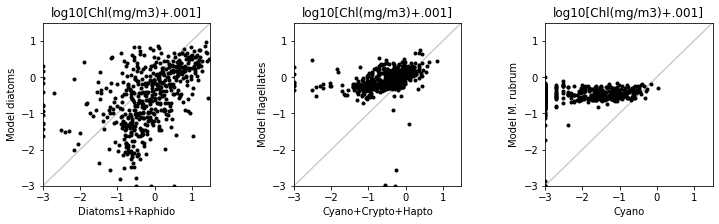

In [42]:
fig,ax=plt.subplots(1,3,figsize=(12,3))
fig.subplots_adjust(wspace=.5)
#ax[0].plot(logt(data['Diatoms-1']+data['Raphidophytes']+.5*data['Cryptophytes']),logt(data['mod_diatoms']),'r.')
ax[0].plot(logt(data['Diatoms-1']+data['Raphidophytes']),logt(data['mod_diatoms']),'k.')
ax[0].set_ylabel('Model diatoms')
ax[0].set_xlabel('Diatoms1+Raphido')
ax[0].set_title('log10[Chl(mg/m3)+.001]')
ax[0].plot((-3,1.5),(-3,1.5),'k-',alpha=.2)
ax[0].set_xlim((-3,1.5))
ax[0].set_ylim((-3,1.5))

ax[1].plot(logt(data['Cyanobacteria']+data['Cryptophytes']+data['Haptophytes']),logt(data['mod_flagellates']),'k.')
ax[1].set_ylabel('Model flagellates')
ax[1].set_xlabel('Cyano+Crypto+Hapto')
ax[1].set_title('log10[Chl(mg/m3)+.001]')
ax[1].plot((-3,1.5),(-3,1.5),'k-',alpha=.2)
ax[1].set_xlim((-3,1.5))
ax[1].set_ylim((-3,1.5))


ax[2].plot(logt(data['Cyanobacteria']),logt(data['mod_ciliates']),'k.')
ax[2].set_ylabel('Model M. rubrum')
ax[2].set_xlabel('Cyano')
ax[2].set_title('log10[Chl(mg/m3)+.001]')
ax[2].plot((-3,1.5),(-3,1.5),'k-',alpha=.2)
ax[2].set_xlim((-3,1.5))
ax[2].set_ylim((-3,1.5))

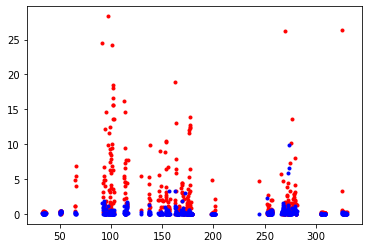

In [43]:
plt.plot(data['yd'],data['Diatoms-1'],'r.')
plt.plot(data['yd'],data['Diatoms-2'],'b.')

(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([1.5822499964913814, 1.6822499964913815, 1.7822499964913814,
        1.8822499964913815, 1.9822499964913813, 2.0822499964913814,
        2.1822499964913815, 2.2822499964913816, 2.3822499964913817,
        2.4822499964913813, 2.5822499964913814], dtype=object),
 <a list of 10 Patch objects>)

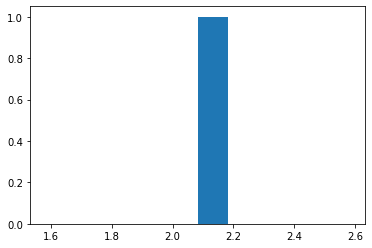

In [44]:
plt.hist(data.loc[ii,['Z']])

### Which HPLC groups are significant?

Text(0, 0.5, 'Count')

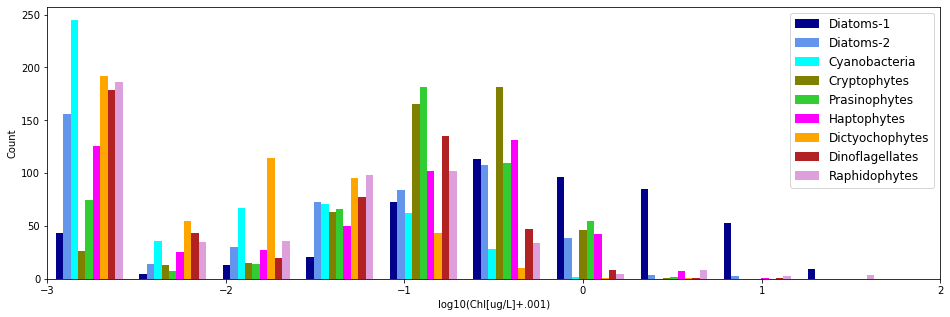

In [110]:
fig,ax=plt.subplots(1,1,figsize=(16,5))
hplclist=('Diatoms-1', 'Diatoms-2','Cyanobacteria','Cryptophytes', 'Prasinophytes', 
       'Haptophytes',  'Dictyochophytes','Dinoflagellates','Raphidophytes')
x=np.array([logt(data[el]) for el in hplclist]).T
cols=('darkblue','cornflowerblue','cyan','olive','limegreen','magenta','orange','firebrick','plum')
n_bins=10
ax.hist(x, n_bins, density=False, histtype='bar', color=cols, label=hplclist);
ax.legend(prop={'size': 12});
ax.set_xlim(-3,2)
ax.set_xlabel('log10(Chl[ug/L]+.001)')
ax.set_ylabel('Count')

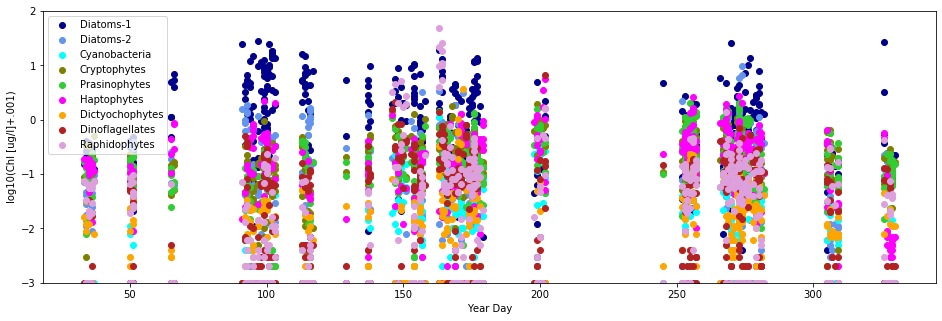

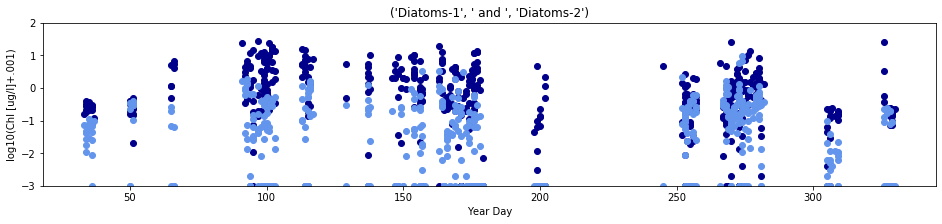

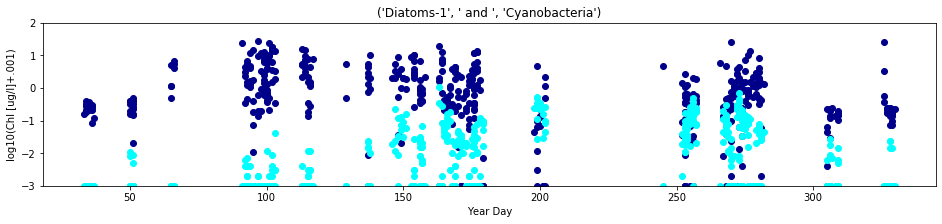

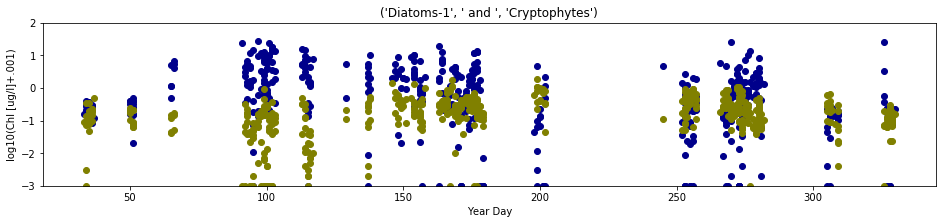

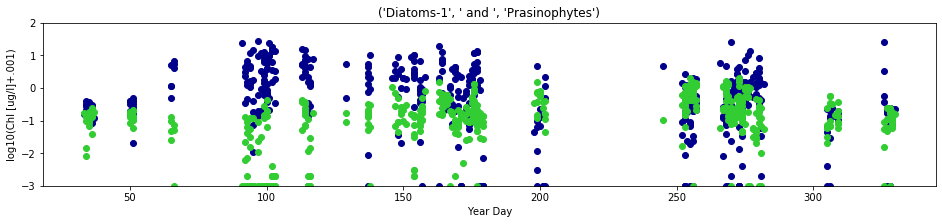

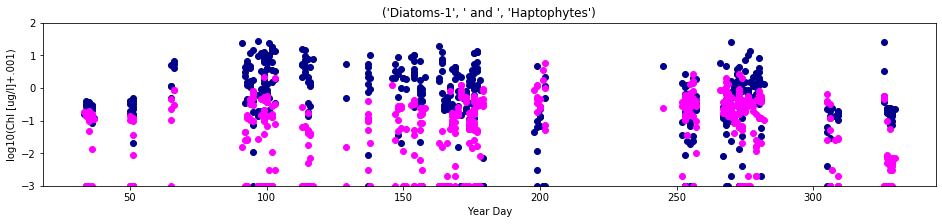

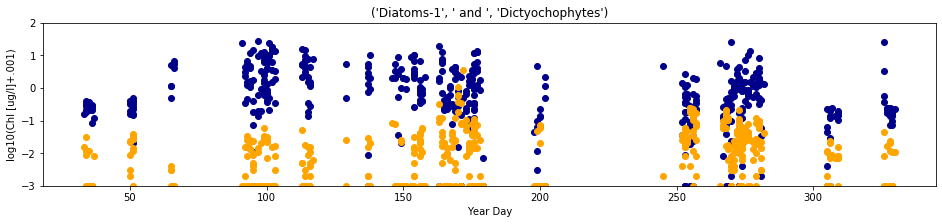

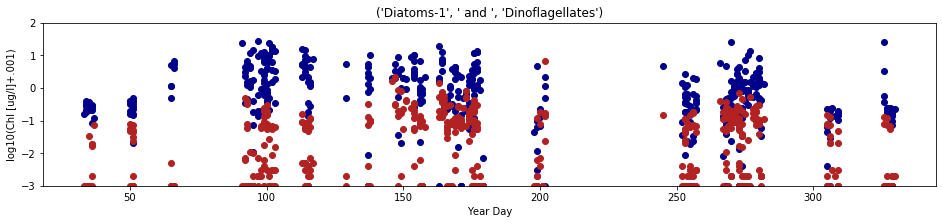

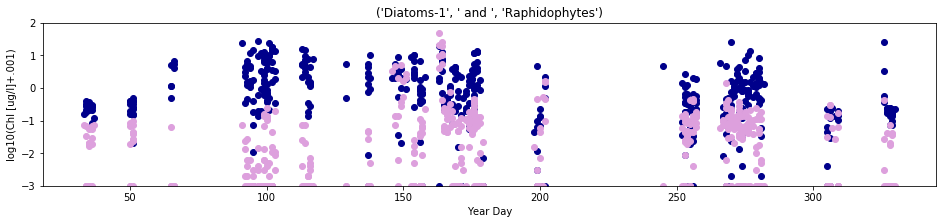

In [112]:

hplclist=('Diatoms-1', 'Diatoms-2','Cyanobacteria','Cryptophytes', 'Prasinophytes', 
       'Haptophytes',  'Dictyochophytes','Dinoflagellates','Raphidophytes')
fig,ax=plt.subplots(1,1,figsize=(16,5))
for i in range(0,len(hplclist)):
    ax.plot(data['yd'],x[:,i],'o',color=cols[i],label=hplclist[i])
    ax.legend()
    ax.set_ylim(-3,2)
    ax.set_xlabel('Year Day')
    ax.set_ylabel('log10(Chl [ug/l]+.001)')
for i in range(1,len(hplclist)):
    fig,ax=plt.subplots(1,1,figsize=(16,3))
    ax.plot(data['yd'],x[:,0],'o',color=cols[0],label=hplclist[0])
    ax.plot(data['yd'],x[:,i],'o',color=cols[i],label=hplclist[i])
    ax.set_ylim(-3,2)
    ax.set_title((hplclist[0],' and ',hplclist[i]))
    ax.set_xlabel('Year Day')
    ax.set_ylabel('log10(Chl [ug/l]+.001)')

In [86]:
np.shape(x)

(5607, 9)